## Notebook for the final assignment in the course "Applied Data Science Capstone"

This course, along with 8 others, are part of the IBM Data Science Professional Certificate

##### Imports

In [123]:
#!conda install -c anaconda beautifulsoup4 -y
#!conda install -c anaconda lxml -y
#!conda install -c conda-forge geocoder --yes 
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes'

# Credentials for Google and Foursquare
GOOGLE_API = ""
FS_ID = ""
FS_SECRET = ""

# Computations
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium

# Webscraping & file processing
import bs4 as bs
from bs4 import BeautifulSoup
import requests
import json
from pandas.io.json import json_normalize

# Geograpic API
import geocoder
from geopy.geocoders import Nominatim

# Machine learning
from sklearn.cluster import KMeans

print("Libraries imported")

Libraries imported


#### 1. Build the neighbourhood dataframe by web scraping 

First, we collect a list of the Toronto neighbourhoods

In [8]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(url, 'lxml')

# Make dataframe and set data types
df = pd.read_html(str(soup.table))[0]
df = df.astype(str)
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,nan
1,M2A,Not assigned,nan
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


As we can see, there are some incomplete rows, so we:
1. Delete all rows without a Borough
2. Assign a Neighbourhood the same name as it's Borough if it is missing a name


In [21]:
# 1. Delete all rows without a Borough
df = df[df.Borough != "Not assigned"]
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [27]:
# 2. Assign a Neighbourhood the same name as it's Borough if it is missing a name
df.loc[df["Neighborhood"] == "Not assigned", ["Neighborhood"]] = df["Borough"]
df.reset_index(inplace=True, drop=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### 2. Build the neighbourhood demographics dataframe by web scraping 

Secondly, we want to fetch the population data for the corresponding neighbourhoods using web scraping from another wiki-article

In [46]:
url = requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').text

soup = BeautifulSoup(url, 'lxml')
table = soup.find_all("table")[1]

# Make dataframe and set data types
df2 = pd.read_html(str(table))[0]
df2 = df2.astype(str)
df2.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,nan,All,5113149,5903.63,866,9.0,40704,10.6,11.4,nan,nan,nan
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,nan
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,nan
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,nan
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,nan


Next, this table has several unwanted columns, so we drop all but the "Name" and "Population" columns, and then fix the datatypes of these

In [47]:
# drop unwanted columns
df2 = df2[["Name", "Population"]]
df2 = df2[df2.Name != "Toronto CMA Average"]
df2.reset_index(inplace=True, drop=True)
df2.rename(columns={"Name":"Neighborhood"}, inplace = True)

# fix datatypes
df2["Population"] = df2["Population"].apply(pd.to_numeric)
df2.head()

,Neighborhood,Population
0,Agincourt,44577
1,Alderwood,11656
2,Alexandra Park,4355
3,Allenby,2513
4,Amesbury,17318


#### 3. Find out the geographical coordinates of each neighbourhood

With the data collected and cleaned, let's append the data with latitudes and longitudes

In [104]:
df["Latitude"] = ""
df["Longitude"] = ""
df2["Latitude"] = ""
df2["Longitude"] = ""

In [105]:
# Loop through each of the arrays
#for i, data in df.iterrows():
#    coords = None
#    while (coords is None):
#        g = geocoder.google("{}, Toronto, Ontario".format(data["Neighborhood"]), key=GOOGLE_API)
#        coords = g.latlng
#        
#    data["Latitude"] = coords[0]
#    data["Longitude"] = coords[1]
#    print(data["Neighborhood"], " at", data["Latitude"], ",", data["Longitude"])

for i, data2 in df2.iterrows():
    coords = None
    while (coords is None):
        g = geocoder.google("{}, Toronto, Ontario".format(data2["Neighborhood"]), key=GOOGLE_API, rate_limit=False)
        coords = g.latlng
        
    df2.loc[i, "Latitude"] = coords[0]
    df2.loc[i, "Longitude"] = coords[1]
    print(data2["Neighborhood"], " at", coords[0], ",", coords[1])

Old East York  at 43.692042 , -79.33775159999999
Woburn  at 43.7764702 , -79.2317279
Elia (Jane and Finch)  at 43.7572667 , -79.5176918
L'Amoreaux  at 43.7967612 , -79.3157737
Agincourt  at 43.788009 , -79.283882
Malvern  at 43.80916 , -79.22169
Willowdale  at 43.7711708 , -79.4197497
Downsview  at 43.7266992 , -79.4820609
Newtonbrook  at 43.7870678 , -79.41731539999999
Smithfield  at 43.7411486 , -79.5892382
Fairbank  at 43.6979339 , -79.4511402
Riverdale  at 43.678985 , -79.34491009999999
Don Valley Village  at 43.787359 , -79.353003
Bendale  at 43.765434 , -79.248935
Parkdale  at 43.643832 , -79.442534
Humewood–Cedarvale  at 43.694479 , -79.428056
Tam O'Shanter – Sullivan  at 43.7810585 , -79.2981138
Parkwoods  at 43.7527765 , -79.32643999999999
Milliken  at 43.8259985 , -79.29731249999999
York University Heights  at 43.7664492 , -79.4774456
Richview  at 43.6886467 , -79.54284009999999
Scarborough Junction  at 43.7248777 , -79.2539764
West Hill  at 43.769163 , -79.182803
Steeles  at

In [106]:
# Print out new dataframes
df2.head(10)

,Neighborhood,Population,Latitude,Longitude,Population (norm)
112,Old East York,52220,43.692,-79.3378,2.161626
169,Woburn,48507,43.7765,-79.2317,2.007928
49,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065
85,L'Amoreaux,45862,43.7968,-79.3158,1.898439
0,Agincourt,44577,43.788,-79.2839,1.845247
97,Malvern,44324,43.8092,-79.2217,1.834774
167,Willowdale,43144,43.7712,-79.4197,1.785929
43,Downsview,36613,43.7267,-79.4821,1.515581
107,Newtonbrook,36046,43.7871,-79.4173,1.492110
138,Smithfield,34996,43.7411,-79.5892,1.448645


#### 4. Renormalise the population with respect to the total Toronto population

In [185]:
total_population = df2["Population"].sum()
df2["Population (norm)"] = df2["Population"]*100/total_population
df2 = df2.sort_values("Population", ascending=False)
df2.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm)
112,Old East York,52220,43.692,-79.3378,0.021616
169,Woburn,48507,43.7765,-79.2317,0.020079
49,Elia (Jane and Finch),48003,43.7573,-79.5177,0.019871
85,L'Amoreaux,45862,43.7968,-79.3158,0.018984
0,Agincourt,44577,43.788,-79.2839,0.018452


Let's also visualize this!

Text(0.5, 1.0, '5 most and 5 least inhabited neighbourhoods in Toronto')

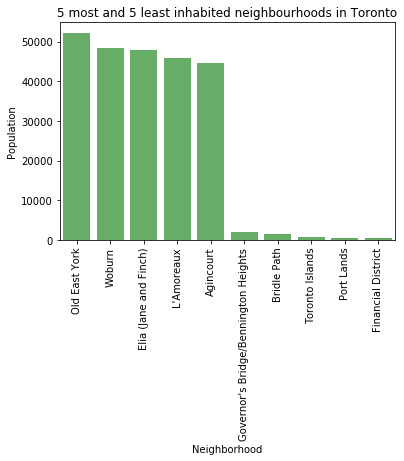

In [108]:
data = pd.concat([df2.head(), df2.tail()])
pop_ax = sns.barplot(x="Neighborhood", y="Population", data=data, color="#5cb85c")

pop_ax.set_xticklabels(pop_ax.get_xticklabels(), rotation=90)
pop_ax.set_title("5 most and 5 least inhabited neighbourhoods in Toronto")

In [114]:
print('The dataframe has {} unique neighbourhoods.'.format(len(df2['Neighborhood'].unique()),df2.shape[0]))

The dataframe has 174 unique neighbourhoods.


#### 5. Map over Toronto with the Neighbourhoods overlayed

Before we fetch the amount of venues in each neighbourhood, we visualize our geodata. To do this, we first fetch the geographical coordinates for Toronto:

In [117]:
coords = None
while (coords is None):
    g = geocoder.google("Toronto, Ontario", key=GOOGLE_API, rate_limit=False)
    coords = g.latlng

print("Toronto, ON is located at {}, {}".format(coords[0], coords[1]))

Toronto, ON is located at 43.653226, -79.3831843


In [122]:
# Create map with folium
map_toronto = folium.Map(location=[coords[0], coords[1]], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

#### 6. Foursquare API to locate grocery retailers within each neighbourhood

Define our credentials and a function which returns a list of venues for each neighbourhood

In [128]:
# Credentials to use with our queries (defined above)
CLIENT_ID = FS_ID
CLIENT_SECRET = FS_SECRET
VERSION = "20180605"
LIMIT = 100

# Function thal loops through a list of neighbourhoods, returning the venues within
# a specified radius along with their category in a new dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

With that set up, we are ready to call Foursquare with our list of neighbourhoods

In [129]:
toronto_venues = getNearbyVenues(names = df2["Neighborhood"],
                                latitudes = df2["Latitude"],
                                longitudes = df2["Longitude"],
                                radius=500)

print(toronto_venues.shape)
toronto_venues.head()

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux
Agincourt
Malvern
Willowdale
Downsview
Newtonbrook
Smithfield
Fairbank
Riverdale
Don Valley Village
Bendale
Parkdale
Humewood–Cedarvale
Tam O'Shanter – Sullivan
Parkwoods
Milliken
York University Heights
Richview
Scarborough Junction
West Hill
Steeles
Forest Hill
Davisville
Leslieville
High Park North
Rouge
Eglinton East
East Danforth
Don Mills
Flemingdon Park
Mount Dennis
The Beaches
Maple Leaf
Upper Beaches
Eatonville
Glen Park
Hillcrest
Thorncliffe Park
Wexford
Silverthorn
O'Connor–Parkview
Sunnylea
York Mills
Amesbury
Earlscourt
Victoria Village
Thistletown
Pleasant View
Islington – Six Points
Weston
Scarborough City Centre
Westminster
Kingsview Village
Roncesvalles
The Annex
Deer Park
Bathurst Manor
Humbermede
St. James Town
Cliffcrest
Humber Valley Village
Harbourfront / CityPlace
Mimico
Dorset Park
Leaside
Lawrence Manor
Bedford Park
Wilson Heights
Church and Wellesley
Oakridge
Bayview Woods – Steeles
Ionview
Highland Creek
G

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old East York,43.692042,-79.337752,The Ritz Restaurant,43.691812,-79.342109,Breakfast Spot
1,Old East York,43.692042,-79.337752,Fresh from the Farm (Amish & Mennonite Meats),43.693331,-79.342574,Gourmet Shop
2,Old East York,43.692042,-79.337752,Select Bakery,43.694108,-79.342793,Bakery
3,Old East York,43.692042,-79.337752,The Beer Store,43.694266,-79.342926,Beer Store
4,Old East York,43.692042,-79.337752,Dieppe Park,43.692207,-79.336074,Park


So we got 3282 results, let's find out how many unique categories (& results per neighbourhood) we had!

In [142]:
toronto_venues.groupby("Neighbourhood")["Venue"].count()

Neighbourhood
Agincourt                    1
Alderwood                   10
Alexandra Park             100
Allenby                     19
Amesbury                     5
                          ... 
Woburn                      16
Wychwood                    15
York Mills                   4
York University Heights      6
Yorkville                  100
Name: Venue, Length: 172, dtype: int64

In [133]:
print("There were {} unique venue categories".format(len(toronto_venues["Venue Category"].unique())))

There were 313 unique venue categories


#### 7. Determine the most prominent venue categories

We now want to list the most commonly occuring venue categories per neighbourhood

In [145]:
# One Hot enc.
toronto_oh = pd.get_dummies(toronto_venues[["Venue Category"]], prefix="", prefix_sep="")
toronto_oh["Neighbourhood"] = toronto_venues["Neighbourhood"] 

# Shuffle columns
fixed_columns = [toronto_oh.columns[-1]] + list(toronto_oh.columns[:-1])
toronto_oh = toronto_oh[fixed_columns]

print(toronto_oh.shape)
toronto_oh.head()

(3282, 314)


,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Old East York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Old East York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Old East York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Old East York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Old East York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
# Group rows by neighbourhood and mean of freq. 
toronto_gr = toronto_oh.groupby("Neighbourhood").mean().reset_index()

print(toronto_gr.shape)
toronto_gr.head()

(172, 314)


,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00
1,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,Alexandra Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.03
3,Allenby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00
4,Amesbury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00


Next, we want to extract the most frequent occuring venue categories

In [159]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Number of categories
num_categories = 10

cols = ["Neighbourhood"]

for i in np.arange(num_categories):
    cols.append("{} Most Common Venue".format(i+1))

neighborhoods_venues = pd.DataFrame(columns = cols)
neighborhoods_venues["Neighbourhood"] = toronto_gr["Neighbourhood"]

for ind in np.arange(toronto_gr.shape[0]):
    neighborhoods_venues.iloc[ind, 1:] = return_most_common_venues(toronto_gr.iloc[ind, :], num_categories)

neighborhoods_venues.head()

,Neighbourhood,1 Most Common Venue,2 Most Common Venue,3 Most Common Venue,4 Most Common Venue,5 Most Common Venue,6 Most Common Venue,7 Most Common Venue,8 Most Common Venue,9 Most Common Venue,10 Most Common Venue
0,Agincourt,Coffee Shop,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
1,Alderwood,Pizza Place,Pool,Dance Studio,Pub,Pharmacy,Skating Rink,Sandwich Place,Coffee Shop,Gym,Event Space
2,Alexandra Park,Bar,Café,Furniture / Home Store,Yoga Studio,Vegetarian / Vegan Restaurant,French Restaurant,Caribbean Restaurant,Coffee Shop,Gym,Park
3,Allenby,Sushi Restaurant,Coffee Shop,Italian Restaurant,Deli / Bodega,Gym,Café,Liquor Store,Gastropub,Tea Room,Spa
4,Amesbury,Café,Construction & Landscaping,Park,Fast Food Restaurant,Bakery,Flea Market,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant


Now, we want to create an aggregate score of the neighbourhoods representing the density of shops, delis and markets

In [162]:
neighborhoods_venues["Competition score"] = 0
competition = ["Shop", "Deli", "Market"]
comp = competition[0]

# A higher competition score means less competition
for i in np.arange(num_categories):
    j = num_categories - i
    col = "{} Most Common Venue".format(j)
    neighborhoods_venues.loc[  neighborhoods_venues[col].str.contains(comp), ["Competition score"]] = (i+1)/num_categories
    
data = pd.merge(df2, neighborhoods_venues, left_on="Neighborhood", right_on="Neighbourhood")
data = data.drop("Neighbourhood", 1)

for i in np.arange(num_categories):
    data = data.drop("{} Most Common Venue".format(1+i), 1)
    
data.head(10)

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score
0,Old East York,52220,43.692,-79.3378,2.161626,0.7
1,Woburn,48507,43.7765,-79.2317,2.007928,1.0
2,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065,0.8
3,L'Amoreaux,45862,43.7968,-79.3158,1.898439,0.4
4,Agincourt,44577,43.788,-79.2839,1.845247,1.0
5,Malvern,44324,43.8092,-79.2217,1.834774,0.4
6,Willowdale,43144,43.7712,-79.4197,1.785929,0.0
7,Downsview,36613,43.7267,-79.4821,1.515581,0.0
8,Newtonbrook,36046,43.7871,-79.4173,1.492110,0.8
9,Smithfield,34996,43.7411,-79.5892,1.448645,0.3


To get a nice 1D score, we merge the population norm and competition score by equal weight

In [163]:
pop_weight = 0.5
comp_weight = 1-pop_weight

data["Score"] = data["Population (norm)"]*pop_weight  +   data["Competition score"]*comp_weight
data = data.sort_values("Score", ascending=False)
data.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score
1,Woburn,48507,43.7765,-79.2317,2.007928,1.0,1.503964
0,Old East York,52220,43.692,-79.3378,2.161626,0.7,1.430813
4,Agincourt,44577,43.788,-79.2839,1.845247,1.0,1.422624
2,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065,0.8,1.393533
10,Fairbank,34121,43.6979,-79.4511,1.412425,1.0,1.206213


### 8. Clustering and Machine Learning

Now, we are ready to cluster the neighbourhoods according to their score (which is a 50/50 weighted score based on population density and presence of competition). A high score is representative of a "good" area to expand into

In [165]:
# Fit 5 clusters
kmeans = KMeans(n_clusters = 5, random_state=0).fit(data[["Population (norm)", "Competition score", "Score"]])
kmeans.labels_[0:10]

array([4, 4, 4, 4, 2, 4, 2, 4, 2, 2], dtype=int32)

In [166]:
# Append results to data structure
data["Cluster"] = kmeans.labels_

data.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
1,Woburn,48507,43.7765,-79.2317,2.007928,1.0,1.503964,4
0,Old East York,52220,43.692,-79.3378,2.161626,0.7,1.430813,4
4,Agincourt,44577,43.788,-79.2839,1.845247,1.0,1.422624,4
2,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065,0.8,1.393533,4
10,Fairbank,34121,43.6979,-79.4511,1.412425,1.0,1.206213,2


Let's now visualise the clusters on a map of Toronto

In [170]:
# Create map with folium
map_clusters = folium.Map(location=[coords[0], coords[1]], zoom_start=11)

# Create color scheme for clusters
x = np.arange(5)
ys = [i+x+(i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, neighborhood, cluster in zip(data['Latitude'], data['Longitude'], data['Neighborhood'], data["Cluster"]):
    label = '{} in cluster {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  

map_clusters

### 9. Cluster-by-cluster evaluation

##### Top 5 overall score neighbourhoods

In [172]:
data = data.sort_values("Score", ascending=False)
data.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
1,Woburn,48507,43.7765,-79.2317,2.007928,1.0,1.503964,4
0,Old East York,52220,43.692,-79.3378,2.161626,0.7,1.430813,4
4,Agincourt,44577,43.788,-79.2839,1.845247,1.0,1.422624,4
2,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065,0.8,1.393533,4
10,Fairbank,34121,43.6979,-79.4511,1.412425,1.0,1.206213,2


##### Cluster 1: Top 5 neighbourhoods

In [176]:
c1 = data[data["Cluster"] == 1]
c1 = c1.sort_values("Score", ascending=False)
c1.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
63,Humber Valley Village,14453,43.6671,-79.528,0.598276,0.0,0.299138,1
66,Dorset Park,14189,43.7658,-79.2811,0.587348,0.0,0.293674,1
67,Leaside,13876,43.7131,-79.3671,0.574391,0.0,0.287196,1
69,Bedford Park,13749,43.7303,-79.4114,0.569134,0.0,0.284567,1
70,Wilson Heights,13732,43.7487,-79.4467,0.568431,0.0,0.284215,1


##### Cluster 2: Top 5 neighbourhoods

In [177]:
c2 = data[data["Cluster"] == 2]
c2 = c2.sort_values("Score", ascending=False)
c2.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
10,Fairbank,34121,43.6979,-79.4511,1.412425,1.0,1.206213,2
8,Newtonbrook,36046,43.7871,-79.4173,1.492110,0.8,1.146055,2
11,Riverdale,31007,43.679,-79.3449,1.283522,0.9,1.091761,2
14,Parkdale,28367,43.6438,-79.4425,1.174241,1.0,1.087120,2
19,York University Heights,26140,43.7664,-79.4774,1.082055,1.0,1.041027,2


##### Cluster 3: Top 5 neighbourhoods

In [178]:
c3 = data[data["Cluster"] == 3]
c3 = c3.sort_values("Score", ascending=False)
c3.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
7,Downsview,36613,43.7267,-79.4821,1.515581,0.0,0.757790,3
18,Milliken,26272,43.826,-79.2973,1.087519,0.3,0.693759,3
33,Mount Dennis,21284,43.6855,-79.4888,0.881043,0.5,0.690521,3
30,East Danforth,21440,43.685,-79.3152,0.887500,0.4,0.643750,3
39,Hillcrest,18327,43.6782,-79.4268,0.758639,0.5,0.629319,3


##### Cluster 4: Top 5 neighbourhoods

In [179]:
c4 = data[data["Cluster"] == 4]
c4 = c4.sort_values("Score", ascending=False)
c4.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
1,Woburn,48507,43.7765,-79.2317,2.007928,1.0,1.503964,4
0,Old East York,52220,43.692,-79.3378,2.161626,0.7,1.430813,4
4,Agincourt,44577,43.788,-79.2839,1.845247,1.0,1.422624,4
2,Elia (Jane and Finch),48003,43.7573,-79.5177,1.987065,0.8,1.393533,4
3,L'Amoreaux,45862,43.7968,-79.3158,1.898439,0.4,1.149220,4


##### Cluster 5: Top 5 neighbourhoods

In [181]:
c5 = data[data["Cluster"] == 0]
c5 = c5.sort_values("Score", ascending=False)
c5.head()

,Neighborhood,Population,Latitude,Longitude,Population (norm),Competition score,Score,Cluster
56,Roncesvalles,15996,43.6463,-79.4491,0.662148,1.0,0.831074,0
58,Deer Park,15165,43.6881,-79.3941,0.627749,1.0,0.813875,0
61,St. James Town,14666,43.6709,-79.3733,0.607093,1.0,0.803547,0
52,Weston,16476,43.7002,-79.5163,0.682017,0.9,0.791009,0
74,Ionview,13025,43.7308,-79.2739,0.539165,1.0,0.769582,0


### 10. Conclusion

Following, our analysis, it is very apperent that cluster number 4 offers the best option for our client's establishments. Not only does this cluster contain neighbourhoods with large populations (large population score), but the competition of shops are low (i.e. a high competition score). This directly translates to a high-demand-low-competition market where the business opportunities are large.

The other clusters offer a more well-rounded market view, with less supply-demand imbalance. Therefore, the recommendation to our client Good Purchase is to establish their presence in Toronto starting in:

* Cluster #4
* Neighbourhood: Woburn

Future expansion should preferably take place within the same cluster as it offers the same supply-demand imbalance, but the clustering should be redone after a period of time as the market landscape would have shifted. Below is a map of the favored cluster in red:

In [189]:
# Create map with folium
map_clusters = folium.Map(location=[coords[0], coords[1]], zoom_start=10)

# Create color scheme for clusters
x = np.arange(5)
ys = [i+x+(i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, neighborhood, cluster in zip(data['Latitude'], data['Longitude'], data['Neighborhood'], data["Cluster"]):
    label = '{} in cluster {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    
    if cluster != 4:
        cluster = 2
    else:
        cluster = 0
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  

map_clusters